In [1]:
# Import all neccessary libraries
# table data handling
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# multiobjective optimization related
from pymoo.util.nds.fast_non_dominated_sort import fast_non_dominated_sort as ndsort
from pymoo.factory import get_performance_indicator
# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import utils
# others
from tqdm import tqdm

In [2]:
sns.set_theme(style="white", palette="bright")
sns.set_context("paper", font_scale=1.5)

## Read data

In [3]:
# Read data of volve_pred problem
method_file_names = ['lexide', 'nsga', 'rvea']
method_names = ['Lex-DE', 'NSGA-II', 'RVEA']
reps = [1000,1001,1002,2000,2001]

objective_sim_names = ['fitP-F-14', 'fitP-F-12']
objective_cod_names = ['P-F-14', 'P-F-12']

volve_pred_hdfs = []
for i, method_file_name in tqdm(enumerate(method_file_names)):
    for j, rep in enumerate(reps):
        tmp = pd.read_hdf(f'volve-pred/{method_file_name}_{rep}_predicted_fit.hdf5').sort_values(['eval'], ignore_index=True)
        tmp['Method'] = method_names[i] # specify the method
        tmp['Repetition'] = j           # specify the repetition
        tmp_obj_val = tmp[objective_sim_names].values
        nd_idx = ndsort(tmp_obj_val)[0]
        is_nd = np.array([False]*len(tmp))
        is_nd[nd_idx] = True
        tmp['is_nd'] = list(is_nd)      # specify whether the individual is non-dominated
        volve_pred_hdfs.append(tmp)
volve_pred_dat = pd.concat(volve_pred_hdfs).sort_values(['Method','Repetition','eval'])
volve_pred_dat.head(3)

3it [00:35, 11.83s/it]


,failed,well,eval,WOPR:P-F-12,WOPR:P-F-14,WOPR:P-F-15C,WWPR:P-F-12,WWPR:P-F-14,WWPR:P-F-15C,WWCT:P-F-12,...,WWPT:P-F-15C,fit,fit_well,fit_seis,fitP-F-12,fitP-F-14,fitP-F-15C,Method,Repetition,is_nd
0,False,results_2021-04-28_0000_fzylexide_synth_seed10...,1,0.271744,0.433714,1001,0.066668,0.250752,1001,0.108631,...,NaN,0.282173,0.282173,0.0,1.725511,3.071427,NaN,Lex-DE,0,False
1,False,results_2021-04-28_0000_fzylexide_synth_seed10...,2,0.237430,0.533494,1001,0.040683,0.362872,1001,0.069300,...,1001.0,294.751521,294.751521,0.0,1.298048,4.071807,5005.406000,Lex-DE,0,False
2,False,results_2021-04-28_0000_fzylexide_synth_seed10...,3,0.270819,0.387546,1001,0.158892,0.180821,1001,0.101661,...,1001.0,294.778490,294.778490,0.0,2.474621,3.316522,5005.443188,Lex-DE,0,False


## Preprocessing

1. scale the five objective values into $[0,1]$ based on all individuals
2. scale the five objective values into $[0,1]$ based on non-dominated individuals
3. scale the 61 parameter values into $[0,1]$ based on all individuals

In [4]:
# Scale the objective values and parameter values between 0 and 1
scaler = MinMaxScaler()

# scale by all individuals in 3 methods x 5 repetitions x 1500 evaluations
volve_pred_fit_scaled_by_all = scaler.fit_transform(volve_pred_dat[objective_sim_names].to_numpy())
volve_pred_fit_scaled_by_all = pd.DataFrame(volve_pred_fit_scaled_by_all, columns=[f'{item}_scaled_by_all' for item in objective_sim_names])

# scale by all individuals in 3 methods x 5 repetitions x number of non-dominated individuals
volve_pred_fit_scaled_by_nd = scaler.fit(volve_pred_dat[volve_pred_dat.is_nd][objective_sim_names].to_numpy()).transform(volve_pred_dat[objective_sim_names].to_numpy())
volve_pred_fit_scaled_by_nd = pd.DataFrame(volve_pred_fit_scaled_by_nd, columns=[f'{item}_scaled_by_nd' for item in objective_sim_names])

volve_pred_dat_processed = pd.concat([
    volve_pred_dat.reset_index(drop=True),
    volve_pred_fit_scaled_by_all.reset_index(drop=True),
    volve_pred_fit_scaled_by_nd.reset_index(drop=True)
], axis=1)

volve_pred_dat_processed.to_csv('volve_pred.processed.csv', index=False) # save to csv

In [5]:
volve_pred_dat_processed = pd.read_csv('volve_pred.processed.csv')
volve_pred_dat_processed.head(3)

,failed,well,eval,WOPR:P-F-12,WOPR:P-F-14,WOPR:P-F-15C,WWPR:P-F-12,WWPR:P-F-14,WWPR:P-F-15C,WWCT:P-F-12,...,fitP-F-12,fitP-F-14,fitP-F-15C,Method,Repetition,is_nd,fitP-F-14_scaled_by_all,fitP-F-12_scaled_by_all,fitP-F-14_scaled_by_nd,fitP-F-12_scaled_by_nd
0,False,results_2021-04-28_0000_fzylexide_synth_seed10...,1,0.271744,0.433714,1001,0.066668,0.250752,1001,0.108631,...,1.725511,3.071427,NaN,Lex-DE,0,False,0.000247,0.000134,0.311539,0.534860
1,False,results_2021-04-28_0000_fzylexide_synth_seed10...,2,0.237430,0.533494,1001,0.040683,0.362872,1001,0.069300,...,1.298048,4.071807,5005.406000,Lex-DE,0,False,0.000330,0.000099,0.416707,0.393082
2,False,results_2021-04-28_0000_fzylexide_synth_seed10...,3,0.270819,0.387546,1001,0.158892,0.180821,1001,0.101661,...,2.474621,3.316522,5005.443188,Lex-DE,0,False,0.000267,0.000197,0.337305,0.783320


## Scaled hypervolume

In [6]:
# Compute hypervolume
with open('volve_pred.hv.csv', 'w') as f:
    print('Method', 'Repetition', 'Hypervolume', sep=',', file=f)
hv_calculator = get_performance_indicator('hv', ref_point=np.ones(len(objective_sim_names)))
for method_name in method_names:
    for rep in range(len(reps)):
        nd_ind = volve_pred_dat_processed[
            (volve_pred_dat_processed.is_nd) & (volve_pred_dat_processed.Method==method_name) & (volve_pred_dat_processed.Repetition==rep)
        ][[f'{item}_scaled_by_nd' for item in objective_sim_names]].values
        with open('volve_pred.hv.csv', 'a') as f:
            print(method_name, rep, hv_calculator.do(nd_ind), sep=',', file=f)
volve_pred_hv = pd.read_csv('volve_pred.hv.csv')

In [7]:
# Get statistics
volve_pred_hv.groupby(['Method']).aggregate([max, np.argmax, np.median, min, np.mean, np.std]).Hypervolume

,max,argmax,median,min,mean,std
Method,,,,,,
Lex-DE,0.949647,4,0.839987,0.746407,0.857895,0.078827
NSGA-II,0.967404,1,0.935233,0.823441,0.915995,0.054812
RVEA,0.926832,3,0.840399,0.745620,0.840735,0.064820


## Lineplot for the objectives by generations

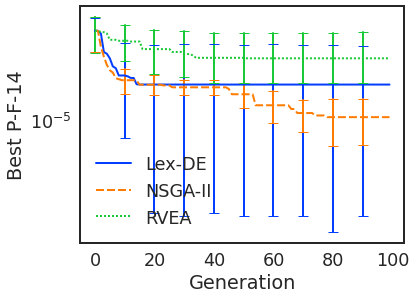

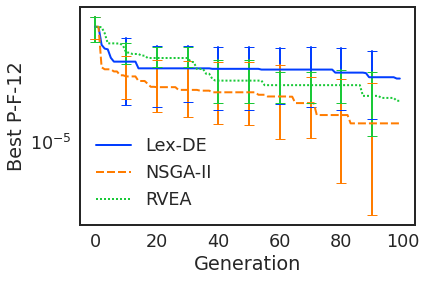

<Figure size 432x288 with 0 Axes>

In [8]:
sns.set_context("paper", font_scale=2., rc={"lines.linewidth": 2, "axes.linewidth": 2})
fig = plt.figure()
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.2, bottom=0.18, right=0.95, top=1)
for i, objective_sim_name in enumerate(objective_sim_names):
    best_fit_dats = []
    for method_name in method_names:
        for rep in range(len(reps)):
            tmp = utils.best_by_gen(
                volve_pred_dat_processed[
                    (volve_pred_dat_processed.Method==method_name) & \
                    (volve_pred_dat_processed.Repetition==rep)
                ][f'{objective_sim_name}_scaled_by_all'].values,
                fit_name=objective_cod_names[i]
            )
            tmp['Method'] = method_name
            tmp['Repetition'] = rep 
            best_fit_dats.append(tmp)
    best_fit_dats = pd.concat(best_fit_dats).reset_index(drop=False)
    sns.lineplot(data=best_fit_dats,
                 x='Generation', y=f'Best {objective_cod_names[i]}',
                 hue='Method', style='Method',
                 err_style="bars", err_kws={"errorevery": 10,
                                            "capsize": 5})
    plt.legend(title='', frameon=False)
    plt.yscale('log')
    plt.savefig(f'volve-pred.{objective_cod_names[i]}.eps')
    plt.show()
    plt.clf()

## Scatterplot for the non-dominated solutions in all runs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

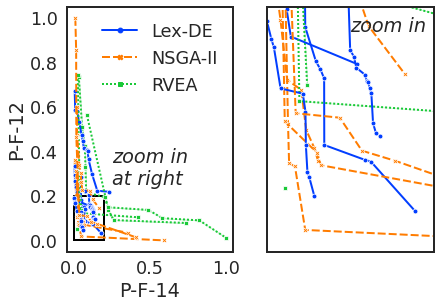

In [9]:
data = volve_pred_dat_processed[
        volve_pred_dat_processed.is_nd
    ][[f'{item}_scaled_by_nd' for item in objective_sim_names]+['Method', 'Repetition']]
data.columns = objective_cod_names + ['Method', 'Repetition']

# plot
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2, "axes.linewidth": 2})
fig = plt.figure()

ax1 = fig.add_subplot(121)
plt.subplots_adjust(left=0.15, bottom=0.15, right=1, top=1)
sns.lineplot(
    data=data[data.Repetition==0], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax1, legend=False
)
sns.lineplot(
    data=data[data.Repetition==1], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax1, legend=False
)
sns.lineplot(
    data=data[data.Repetition==2], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax1, legend=False
)
sns.lineplot(
    data=data[data.Repetition==3], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax1, legend=False
)
sns.lineplot(
    data=data[data.Repetition==4], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax1
)
rect=mpatches.Rectangle((0,0),0.2,0.2, 
                        fill=False,
                        color="black",
                        linewidth=2)

plt.gca().add_patch(rect)

ax2 = fig.add_subplot(122)
plt.subplots_adjust(left=0.15, bottom=0.15, right=1, top=1)
sns.lineplot(
    data=data[data.Repetition==0], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax2, legend=False
)
sns.lineplot(
    data=data[data.Repetition==1], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax2, legend=False
)
sns.lineplot(
    data=data[data.Repetition==2], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax2, legend=False
)
sns.lineplot(
    data=data[data.Repetition==3], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax2, legend=False
)
sns.lineplot(
    data=data[data.Repetition==4], x='P-F-14', y='P-F-12',
    hue='Method', style='Method', markers=['o', 'X', 's'], ax=ax2, legend=False
)
ax2.set_xlim(0, 0.2)
ax2.set_ylim(0, 0.2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")

ax1.text(0.25, 0.25, "zoom in\nat right", fontstyle="oblique")
ax2.text(0.1, 0.18, "zoom in", fontstyle="oblique")

ax1.legend(title='', frameon=False)
plt.savefig('volve-pred.scatter.eps')